# Домашнее задание 1

В этом домашнем задании мы немного поупражняемся с обработкой временных данных и базовыми моделями. 

В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с движениями ликвидности одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день.

#### Описание бизнес-процесса, связанного с рядом.

Ликвидностью обычно называют высоколиквидные активы, т.е. активы, которые легко купить и продать, чтобы быстро конвертировать в деньги. Собственно, сами по себе деньги это тоже ликвидность. Но ими также могут быть ценные бумаги крупных компаний и деривативы на них. Для банков важно поддерживать некоторый уровень ликвидности, чтобы всегда иметь возможность либо быстро отдать краткосрочные долги. Крупнейшие банковские кризисы во многом состоялись из-за набега вкладчиков, забравших свои деньги, из-за чего банки не могли в моменте обслуживать свои займы. Ликвидные активы можно быстро вложить, если на рынке встретились хорошие условия. Если ликвидности избыток, её можно вложить, а если недостаток -- занять.

Мы хотим прогнозировать сумму (сальдо) поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке для получения дополнительной прибыли. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ (дать в долг) по overnight ставке, равной ключевой-0.9%. В случае, если на конец дня образуется дефицит ликвидности (опасность не вернуть долги), его можно покрыть за счет займа по overnight ставке, равной ключевая+1%. 


In [980]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

## 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты во временных данных. Вам необходимо определить частоту данных, так как от этого будут зависеть параметры модели. Исходя из частоты выберите оффсет [Оффсет](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).Не спешите отвечать на этот вопрос и посмотрите на данные **внимательно**. Сделайте ресэмпл ряда к выбранному оффсету. Если вы всё сделали правильно, то дисперсия ряда должна быть примерно одинаковой на любом участке.

In [981]:
df = pd.read_csv('data.csv')
df

,Date,Target
0,2017-01-09 09:00:00.000,0.000000
1,2017-01-09 11:00:00.000,-0.421841
2,2017-01-09 13:00:00.000,0.105555
3,2017-01-09 15:00:00.000,0.042276
4,2017-01-09 17:00:00.000,0.071416
...,...,...
3904,2020-09-11 00:00:00.000,2.180332
3905,2020-09-14 00:00:00.000,3.307929
3906,2020-09-15 00:00:00.000,2.644602
3907,2020-09-16 00:00:00.000,1.977839


In [982]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dtypes

Target    float64
dtype: object

In [983]:
df = df.resample("B").sum()

***По выходным значение целевой переменной всегда нулевое, прогнозирование подобных значений не имеет смысла, поэтому имеет смысл агрегировать по будним дням.***

## 2) Визуальный анализ (0.5 балла)

Изобразите временной ряд, его автокорреляции и частные автокорреляции до порядка, который сочтёте нужным.

Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? Как эти особенности могут помочь прогнозировать?  Ответьте на **каждый** вопрос. 

Хинт: если построить коррелограммы на приращениях ряда, а не на исходных величинах, то некоторые паттерны видны лучше.


***1. Говоря о структуре ряда - можно замтетить, что, скорее всего банк имеет определенную норму ликвидности, вокруг который колебляться фактические значения с определенной периодичностью. При каких-либо внеплановых событиях банк, вероятно, меняет эту норму, из-за чего происходит структурный сдвиг.***

***2. Не сказать, что тут заметен какой-то тренд - скорее, как я уже сказал, значения колеблятся вокруг фиксированного значения без тенденции на рост или спад, однако если не брыть во внимание рассуждение выше, то можно, сказать что есть некоторый растущий тренд, который фактически достигается засчет структурного сдвига.***

***3. Сезонность в этом ряду однозначно присуствует - самая явная из них - недельная сезонность, которую видно на графиках автокорреляции.***

***4. Цикличность, вероятно, тоже есть - она проявляется в периодическом колебании вокруг фиксированного значения.***

***5. Можно сказать, что до структурного сдвига стационарность была, после - тоже. Однако если рассматривать весь график - то ее скорее нет, так как средняя ряда меняется.***

***6. Можно найти, какие показатели точно так же реагируют на подобные внеплановые события и точно так же меняеются, совершая структурный сдивг - например, это может быть ключевая ставка ЦБ. Информация о сезонности может нам помочь выбрать правильные лаги для генерации фичей, а данные о струткурном сдвиге помогут создать переменную, которая позволит лучше обучить модель с учетом этого события.***

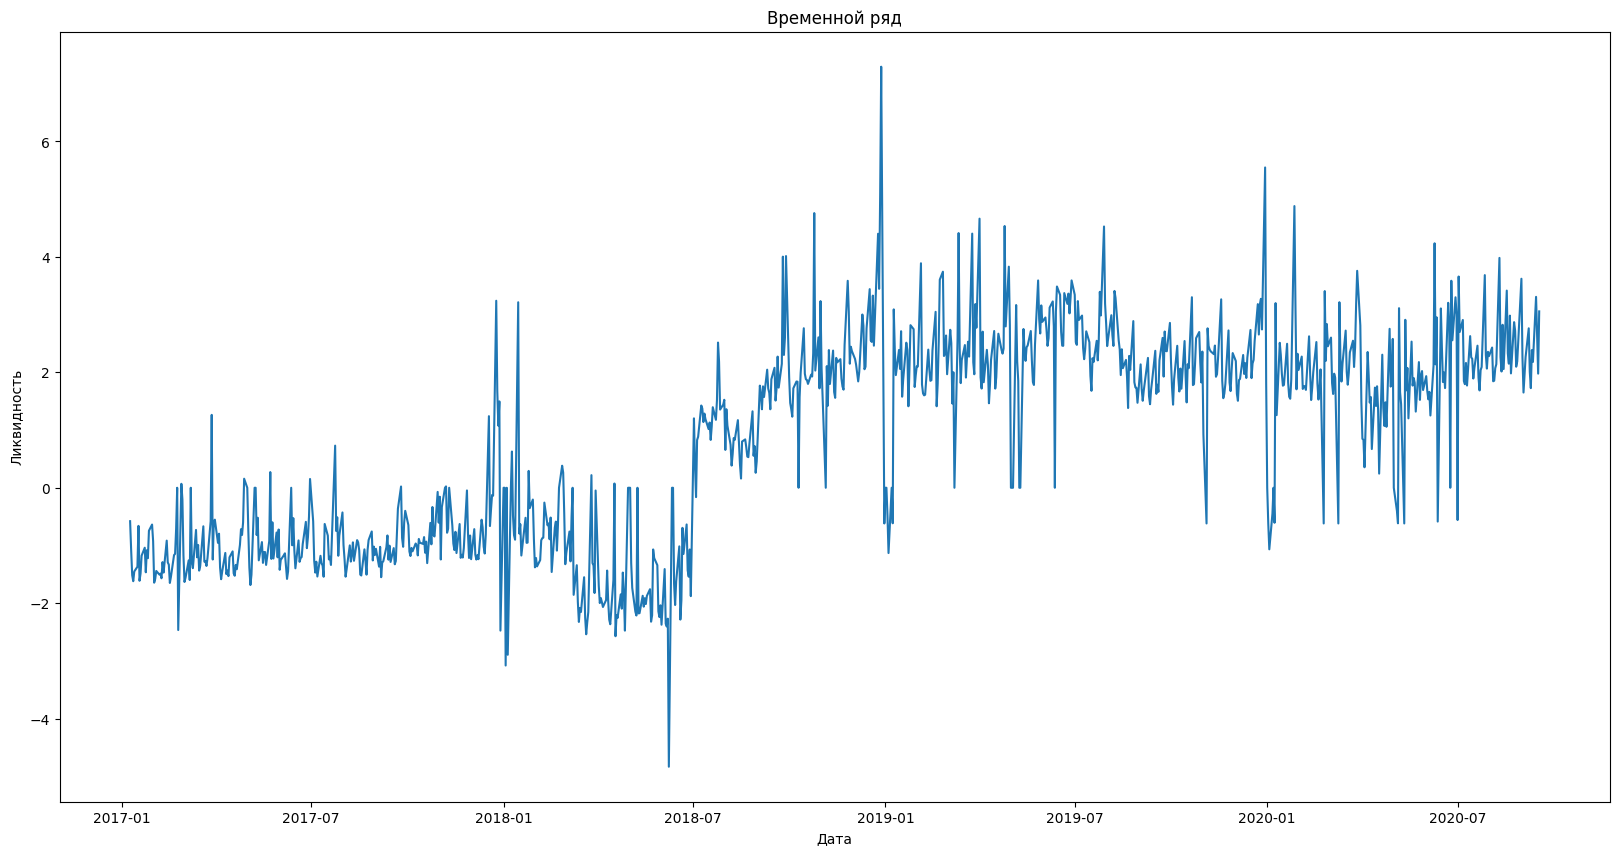

In [984]:
plt.figure(figsize=(20, 10))
plt.plot(df)
plt.title('Временной ряд')
plt.xlabel("Дата")
plt.ylabel("Ликвидность")
plt.show()

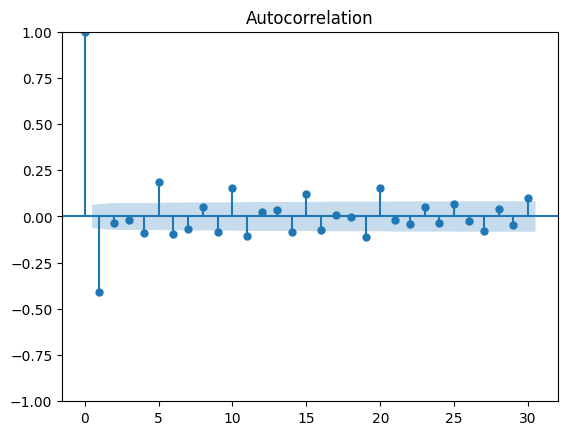

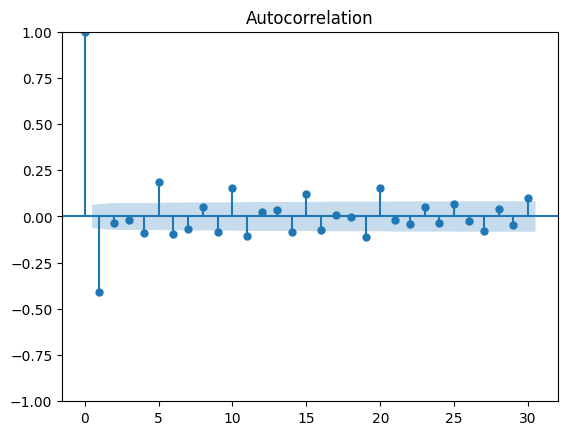

In [985]:
df_diff = df['Target'].diff().dropna()
plot_acf(df_diff)

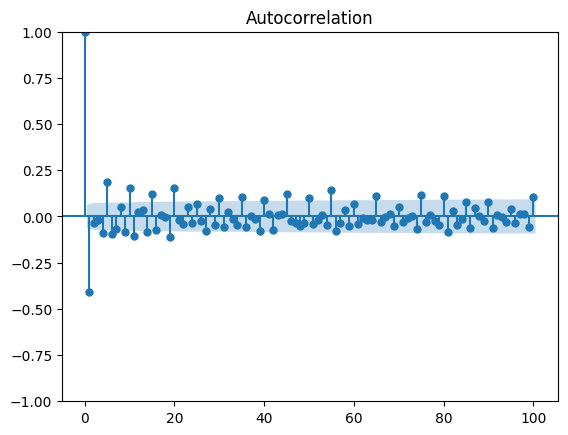

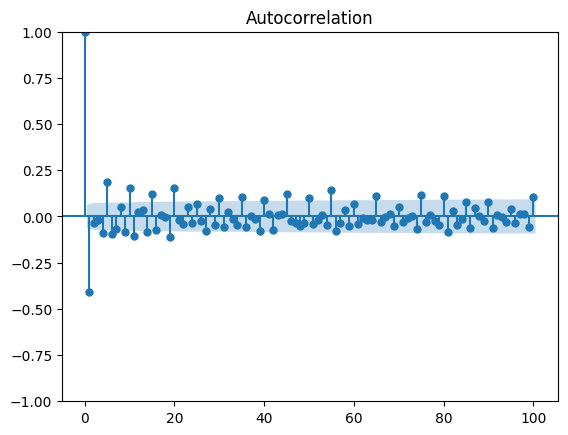

In [986]:
plot_acf(df_diff, lags=100)

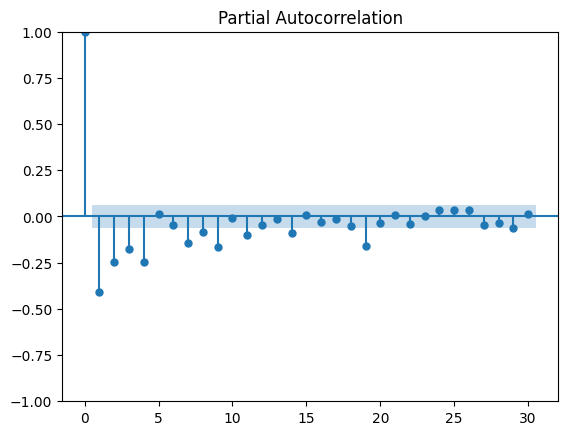

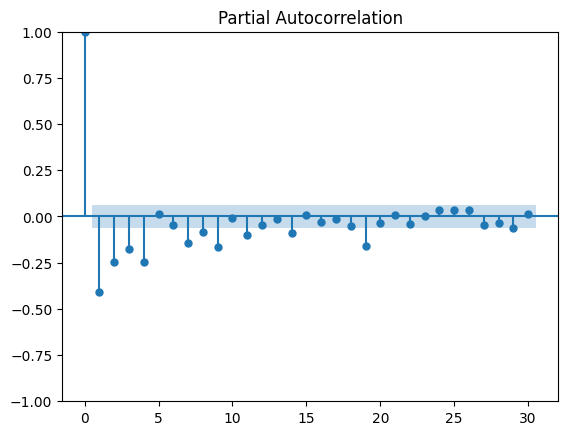

In [987]:
plot_pacf(df_diff)

## 3) Генерация признаков (3 балла)
Во временных рядах очень важно избегать утечек в данных (data leak). Их легко допуситть при неаккуратной генерации признаков. Например, если вы для прогноза $y_t$ будете исплользовать фичу разности $y_t - y_{t-1}$. Будьте осторожны и внимательны.

**Внимание!** При наличии хотя бы одной утечки в данном блоке стоимость всех пунктов делится на 2, кроме бонусного. Итого максимальный балл при наличии утечек равен 1.5 (или 2.5 при сделанном бонусе). 


Создайте следующие признаки. Не забудьте лагировать необходимые фичи. Календарные фичи утечками не являются и могут даже заглядывать в будущее. Фичи с утечками не засчитываются. Выбор каждой фичи необходимо обосновать. Фичи без обоснования не засчитываются.

1) (0.75 балла) Календарные фичи. Придумайте не менее пяти фичей из календаря. Выбор каждой обоснуйте.
2) (0.15 балла) Структурный сдвиг. В середине ряда явно есть структурное изменение. Попробуйте придумать фичу, которая бы помогла это учесть.
3) (1 балл) Бонус! Одна из важных календарных фичей наряду с праздниками -- налоговые (бухгалтерские) дни. Найти их в удобном для чтения формате весьма проблемно, придётся парсить, но это весьма сильная фича. Код парсинга (или описание того, как вы их выкачивали) необходимо приложить, иначе пункт не засчитывается.
4) (0.1 балла) Лаги таргета.  (до 5 разных). Выбор каждого лага обоснуйте.

5) Экзогенные фичи (по 0.5 балла каждый пункт):
<ul>
<li>Значение ключевой ставки. Можно поискать на сайте ЦБ</li>
<li>Обменнык курс доллара. Тоже есть на сайте ЦБ либо в любом другом источнике. Например. YahooFinance</li>
<li>Спред ставок MosЗrime, все 7 показателей. Ставка MosPrime -- ставка кредитования в рублях на межбанковском рынке России. Спред -- разница между ставками кредита и депозита. У mosprime есть свой сайт.</li>
</ul>

6) Придумайте сами 2 фичи, которые считаете необходимыми (по 0.25 за каждую). Выбор каждой фичи обоснуйте.

#### Задание 1

In [988]:
ru_holidays = holidays.Russia()
df['weekday'] = df.index.weekday # как мы увидели на графиках автокорреляции, наблюдается недельная сезонность, поэтому изменения в пятницу новой недели скорее всего будут похожи на изменения в пятницу прошлой недели
df['monthday'] = df.index.day #в какой-то определенный день месяца банк может проводить внутрие или внешние расчеты, подсчитывать ликвидность, поэтому этот признако может быть важен
df['is_holiday'] = df.index.to_series().apply(lambda x: x in ru_holidays) # крайне важный признак, который может сильно улучшить качество - в праздники банковские операции, скорее всего, не совершаются или совершаются в меньшей степени,из-за чего баланс ликвидности отличается от обычного
df['month'] = df.index.month # в определенные месяцы у банка может наблюдаться больший/меньший приток ликвидности в связи с тем, что большая часть клиентов банка - люди, а их поведение подверженно месячной сезонности (мелкие кредиты на новогдние праздники, летний отдых)
df['year'] = df.index.year # обычно, важные законы принимаются в начале года, локальные уставные документы так же обычно меняют свои предписания по годам. Так что, вероятно, если у банка что-то поменяется, это может случиться с началом нового года

#### Задание 2

In [989]:
df['after_shift'] = (df.index > pd.to_datetime('2018-07-01'))*1

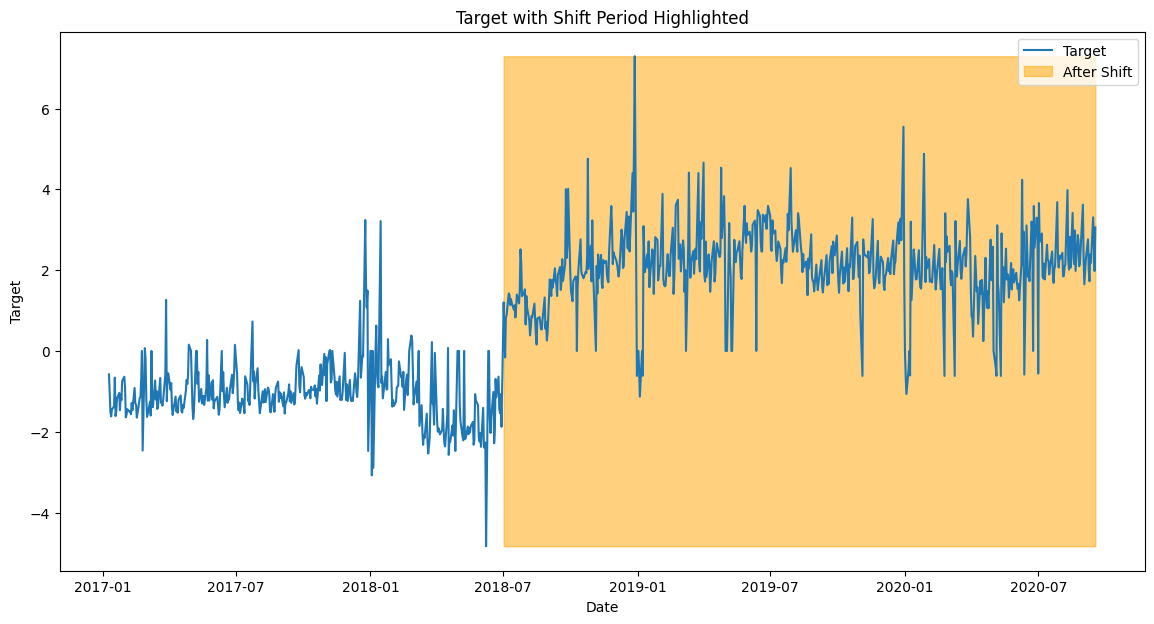

In [990]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Target'], label='Target')

plt.fill_between(df.index, df['Target'].min(), df['Target'].max(),
                 where=df['after_shift'] == 1, color='orange', alpha=0.5, label='After Shift')

plt.title('Target with Shift Period Highlighted')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

#### Задание 4

In [991]:
df['y_L1'] = df['Target'].shift(1) # ликвидность сегодня сильно связана с ликвидностью вчера - если у банка был приток вчера, то сегодня ему надо убрать лишнюю ликвидность, это же видно и на графиках
df['y_L5'] = df['Target'].shift(5) # уже писал о том, что наблюдается сильная недельная сезонность
df['y_L20'] = df['Target'].shift(20) # при прочих равнх банк будет стараться держать ликвидность такую же, как в прошлом месяце. Кроме того, могут быть схожие бухгалтерские или расчетные дни
# df['y_L261'] = df['Target'].shift(260) # аналогично, банк будет стараться держать ликвидность аналогичную прошлому году. кроме того, могут наблюдаться схожие тенденции под начало и конец года

#### Задание 6

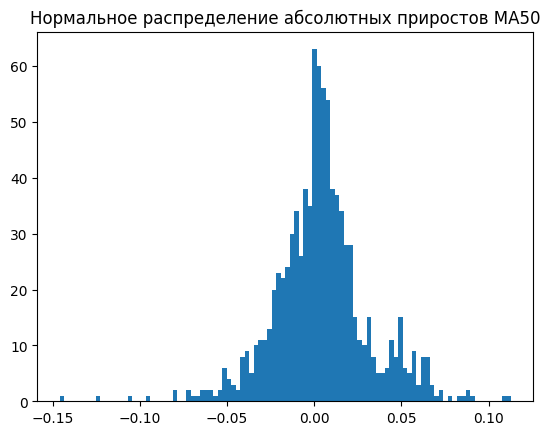

In [992]:
df['MA50'] = df['Target'].rolling(window=50, min_periods=50, closed='left').mean() # утечки не происходит, так как MA строятся только на основе прошлых данных
df['MA100'] = df['Target'].rolling(window=100, min_periods=50, closed='left').mean()
df['MA50_diff'] = df['MA50'].diff()
df['MA50_std'] = df['Target'].rolling(window=50, min_periods=50, closed='left').std()
plt.title('Нормальное распределение абсолютных приростов MA50')
plt.hist(df['MA50_diff'], bins=100)
plt.show()


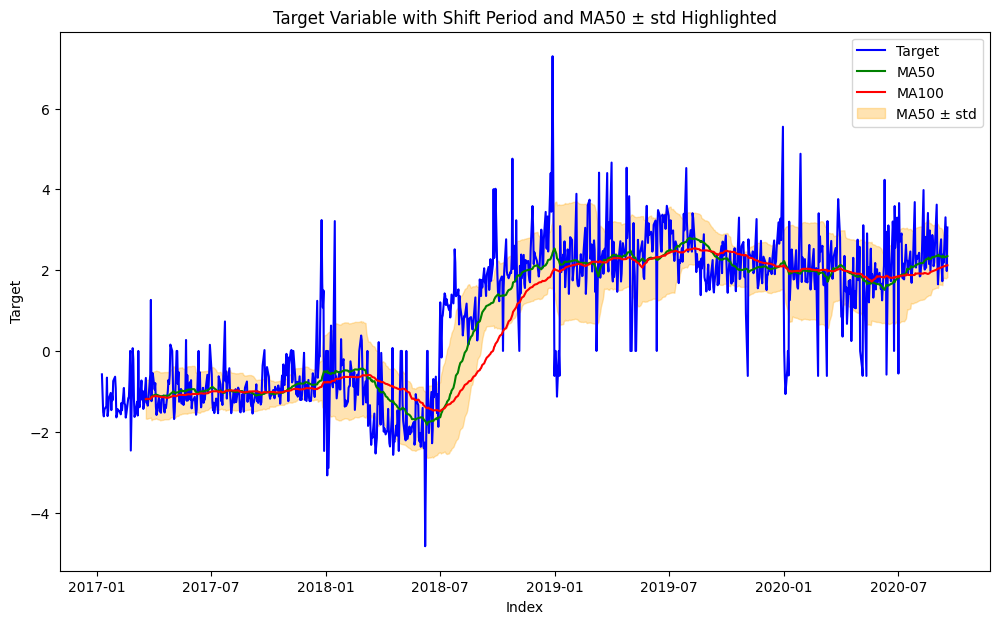

In [993]:
df['MA50_plus_std'] = df['MA50'] + df['MA50_std']
df['MA50_minus_std'] = df['MA50'] - df['MA50_std']

plt.figure(figsize=(12, 7))
plt.plot(df['Target'], label='Target', color='blue')
plt.plot(df['MA50'], label='MA50', color='green')
plt.plot(df['MA100'], label='MA100', color='red')
plt.fill_between(df.index, df['MA50_minus_std'], df['MA50_plus_std'], color='orange', alpha=0.3, label='MA50 ± std')
plt.title('Target Variable with Shift Period and MA50 ± std Highlighted')
plt.xlabel('Index')
plt.ylabel('Target')
plt.legend()
plt.show()

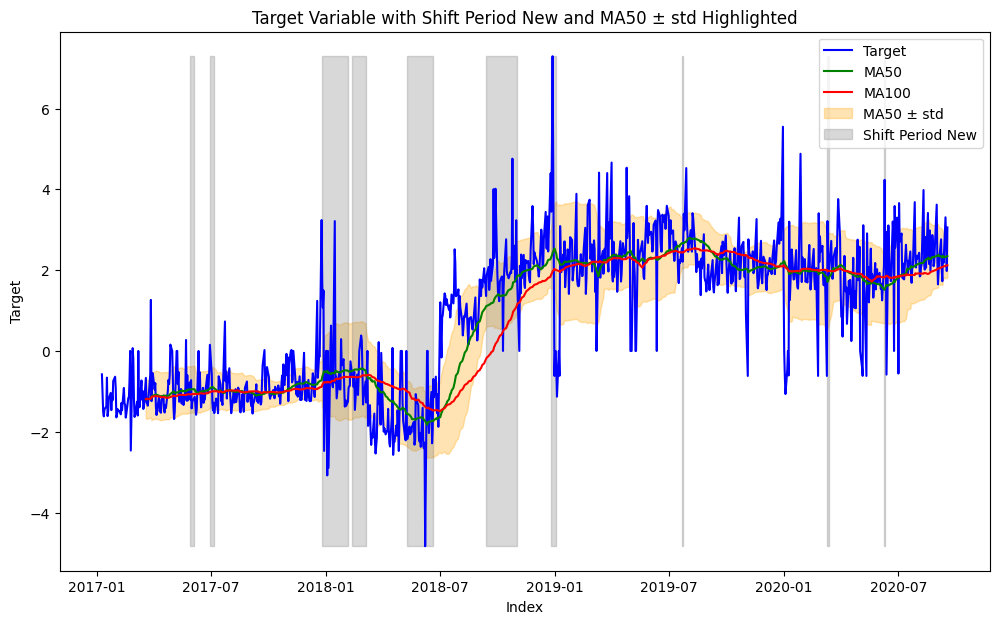

In [994]:
df['MA_diff'] = (df['MA50'] - df['MA100'])
df['MA_diff_std_last_10'] = (df['MA50'] - df['MA100']).rolling(window=50).std()

df['shift_period_new'] = (df['MA_diff'].abs() > 3*df['MA_diff_std_last_10']).astype(int)

plt.figure(figsize=(12, 7))
plt.plot(df['Target'], label='Target', color='blue')
plt.plot(df['MA50'], label='MA50', color='green')
plt.plot(df['MA100'], label='MA100', color='red')
plt.fill_between(df.index, df['MA50_minus_std'], df['MA50_plus_std'], color='orange', alpha=0.3, label='MA50 ± std')
plt.fill_between(df.index, df['Target'].min(), df['Target'].max(), where=df['shift_period_new']==1, color='grey', alpha=0.3, label='Shift Period New')
plt.title('Target Variable with Shift Period New and MA50 ± std Highlighted')
plt.xlabel('Index')
plt.ylabel('Target')
plt.legend()
plt.show()


**Первые две новые переменные - МА50 по большей части и MA100 по меньшей части являются отличной базой для построения прогнозов и уже изначально неплохим прогнозом сами по себе - так как, как я упомянал ранее, ликвидность циклично колеблется от какого-то уровня, скользящие средние будут сглаживать цикличность и хорошо предугадывать будущее значение ликвиности без учета цикличности.**

***Вторая новая переменная, выявляя аномальные расхождения между MA100 и MA50, определяет периоды структурных сдвигов. Признак структурного сдвига в модели линейной регрессии помогает учесть потенциальные изменения в отношениях между зависимой и независимыми переменными, которые могут возникать в определенные периоды. Включение такого признака в модель может позволить лучше прогнозировать целевую переменную, когда известно, что ряд находится в периоде сдвига, так как модель будет корректировать свои оценки, отражая этот новый режим данных. Это может улучшить точность прогнозов и сделать их более релевантными для текущих условий.***

In [995]:
print(df.columns)
df.drop(['MA50_diff', 'MA_diff', 'MA_diff_std_last_10'], axis=1, inplace=True) # остальные признаки пока оставляю до построения модели, вдруг окажутся полезными


Index(['Target', 'weekday', 'monthday', 'is_holiday', 'month', 'year',
       'after_shift', 'y_L1', 'y_L5', 'y_L20', 'MA50', 'MA100', 'MA50_diff',
       'MA50_std', 'MA50_plus_std', 'MA50_minus_std', 'MA_diff',
       'MA_diff_std_last_10', 'shift_period_new'],
      dtype='object')


#### Задание 5

In [996]:
cb_rate = pd.read_excel('cb_rate.xlsx')
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)
merged_df = pd.merge(df, cb_rate, how='left', left_on='Date', right_on='Дата')
exchange_rate = pd.read_excel('exchange_rate.xlsx')
merged_df = pd.merge(merged_df, exchange_rate, how='left', left_on='Date', right_on='Дата')
mosprime = pd.read_excel('mosprime.xlsx')
merged_df = pd.merge(merged_df, mosprime, how='left', left_on='Date', right_on='Дата')
merged_df


,Date,Target,weekday,monthday,is_holiday,month,year,after_shift,y_L1,y_L5,...,Единиц,Курс,Дата,ON,1W,2W,1M,2M,3M,6M
0,2017-01-09,-0.579194,0,9,False,1,2017,0,NaN,NaN,...,NaN,NaN,2017-01-09,10.46,10.44,10.47,10.52,10.58,10.58,10.58
1,2017-01-10,-1.082260,1,10,False,1,2017,0,-0.579194,NaN,...,1.0,59.8961,2017-01-10,10.21,10.40,10.48,10.53,10.59,10.59,10.59
2,2017-01-11,-1.515704,2,11,False,1,2017,0,-1.082260,NaN,...,1.0,59.9533,2017-01-11,10.23,10.40,10.48,10.53,10.59,10.59,10.59
3,2017-01-12,-1.618853,3,12,False,1,2017,0,-1.515704,NaN,...,1.0,60.1614,2017-01-12,10.23,10.42,10.48,10.53,10.59,10.59,10.59
4,2017-01-13,-1.450091,4,13,False,1,2017,0,-1.618853,NaN,...,1.0,59.4978,2017-01-13,10.27,10.40,10.45,10.51,10.58,10.59,10.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,2020-09-11,2.180332,4,11,False,9,2020,1,2.385552,2.265766,...,1.0,75.5274,2020-09-11,4.36,4.45,4.46,4.50,4.56,4.65,4.67
960,2020-09-14,3.307929,0,14,False,9,2020,1,2.180332,2.762902,...,NaN,NaN,2020-09-14,4.36,4.44,4.44,4.49,4.55,4.63,4.66
961,2020-09-15,2.644602,1,15,False,9,2020,1,3.307929,2.008578,...,1.0,74.7148,2020-09-15,4.37,4.45,4.45,4.50,4.55,4.63,4.66
962,2020-09-16,1.977839,2,16,False,9,2020,1,2.644602,1.726324,...,1.0,75.1884,2020-09-16,4.41,4.46,4.46,4.50,4.55,4.63,4.66


In [997]:
merged_df.drop(['Дата_x', 'Дата_y', 'Дата', 'Единиц'], axis=1, inplace=True)

## 4) Одношаговое прогнозирование (1 балл)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Пункты Регрессия и Бенчмарк не будут засчитаны! 

#### 4.1) Предобработка (0.3 балла)

Разбейте полученные данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные. Если необходимо, закодируйте категориальные фичи любым валидным методом.

In [998]:
merged_df.isna().sum()

Date                  0
Target                0
weekday               0
monthday              0
is_holiday            0
month                 0
year                  0
after_shift           0
y_L1                  1
y_L5                  5
y_L20                20
MA50                 50
MA100                50
MA50_std             50
MA50_plus_std        50
MA50_minus_std       50
shift_period_new      0
Ставка               48
Курс                238
ON                   59
1W                   59
2W                   59
1M                   59
2M                   59
3M                   59
6M                   59
dtype: int64

In [999]:
merged_df_copy = merged_df.copy()
merged_df = merged_df.dropna()
merged_df.set_index('Date', inplace=True)
y = merged_df['Target']
X = merged_df.drop(columns=['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [1000]:
numeric_f = ['is_holiday', 'after_shift', 'y_L1', 'y_L5', 'y_L20', 'MA50', 'MA100', 'shift_period_new',
       'Ставка', 'Курс', 'ON', '1W', '2W', '1M', '2M', '3M', '6M' ]
categorical_f = ['weekday', 'monthday', 'month', 'year']
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train_encoded = encoder.fit_transform(X_train[categorical_f]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_f]).toarray()
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(), index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(), index=X_test.index)

X_train_f = pd.concat([X_train[numeric_f], X_train_encoded], axis=1)
X_test_f = pd.concat([X_test[numeric_f], X_test_encoded], axis=1)

#### 4.2) Регрессия (0.3 балла)

Выберите ваш любимый регрессор и решите задачу одношагового прогнозирования. При необходимости подберите гиперпараметры. Кросс-валидацию мы ещё пройти не успели, поэтому можно отбирать параметры на тесте, держа в голове, что так делать не очень хорошо. Подсчитайте качество одношаговых прогнозов. В качестве метрики используйте WAPE. 

$$WAPE=\frac{\sum_{t=1}^n\left|A_t-F_t\right|}{\sum_{t=1}^n\left|A_t\right|}, \quad A_t - Actual, F_t - Forecast$$

In [1001]:
model = LinearRegression()
model.fit(X_train_f, y_train)
y_pred = model.predict(X_test_f) 

In [1002]:
def wape(y_pred, y_test):
    return (np.sum(abs(y_test - y_pred)) / np.sum(abs(y_test)))

In [1003]:
wape(y_pred, y_test)

0.26645052976293443

#### 4.3) Бенчмарк (0.3 балла)

Постройте прогноз с помощью наивной модели. Наивная модель в качестве прогноза возвращает последнее доступное на текущий момент значение из трейна. Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже. С налоговыми датами почти наверное получится лучше.




In [1004]:
y_naive = y_test.shift(1)
y_naive[pd.to_datetime('2019-12-24')] = y_train[pd.to_datetime('2019-12-20')]

In [1005]:
wape(y_naive, y_test)

0.2205316663107491

#### 4.4) Визуализация (0.1 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели. Подпишите все оси.

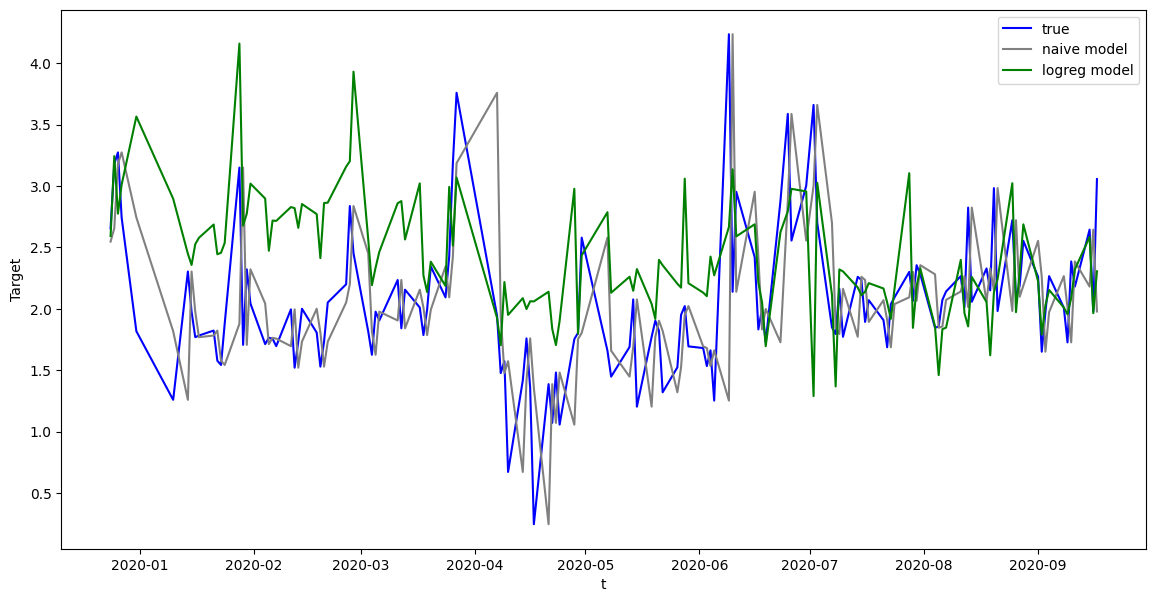

In [1006]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='true', color='blue')
plt.plot(y_test.index, y_naive, label='naive model', color='grey')
plt.plot(y_test.index, y_pred, label='logreg model', color='green')

plt.xlabel('t')
plt.ylabel('Target')
plt.legend()

plt.show()

## 5) Многошаговое прогнозирование


Описание всех необходимых стратегий есть в [Конспекте](https://github.com/Pyatachokk/hse_ts_course/blob/master/2024-spring/seminars/sem_02_tables.pdf)

#### 5.1) Повтор препроцессинга (0 баллов)

Вернёмся к полному датасету. Повторите разбиение на трейн и тест. Возьмём в качестве теста последние 50 наблюдений. Соответственно, горизонт прогнозирования будет равен 50. Для упрощения задачи уберём все экзогенные переменные из датасета, которые нужно прогнозировать. Оставим только лаги таргета, календарные фичи и придуманные вами фичи если их не надо прогнозировать. Повторите нормирование и энкодинг, если делали их ранее и если это необходимо. 

In [1007]:
df = merged_df_copy[['Target', 'weekday', 'monthday', 'is_holiday', 'month', 'year',
       'after_shift', 'y_L1', 'y_L5', 'y_L20', 'MA50', 'MA100']]
df = df.dropna() # в данном случае отпадают только первые 50 наблюдений, все остальные наблюдения последовательны и не содержат пропусков
y = df['Target']
X = df.drop(columns=['Target'])
X_test = X.iloc[-50:]
y_test = y.iloc[-50:]
X_train = X.iloc[:-50]
y_train = y.iloc[:-50]

In [1008]:
numeric_f = ['is_holiday', 'month',
       'after_shift', 'y_L1', 'y_L5', 'y_L20', 'MA50', 'MA100']
categorical_f = ['weekday', 'monthday','year']
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train_encoded = encoder.fit_transform(X_train[categorical_f]).toarray()
X_test_encoded = encoder.transform(X_test[categorical_f]).toarray()
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(), index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(), index=X_test.index)

X_train_f = pd.concat([X_train[numeric_f], X_train_encoded], axis=1)
X_test_f = pd.concat([X_test[numeric_f], X_test_encoded], axis=1)

#### 5.2) Рекурсивная стратегия (2 балла)

Внимание! Внимание! Запрещается пользоваться готовыми функциями. Рекурсивную стратегию необходимо написать вручную!

 Реализуйте рекурсивное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [1009]:
start = X_train.shape[0]

In [1010]:
model = LinearRegression() #start = 626
model.fit(X_train_f, y_train)
preds_rec = []

X_test_temp = X_test_f.copy()
X_test_temp['Target'] = y_test
X_train_temp = X_train_f.copy()
X_train_temp['Target'] = y_train
X_temp = pd.concat([X_train_temp, X_test_temp])
for i in range(50):
    pred = model.predict(X_temp.iloc[[start+i]].drop(columns=['Target']))
    preds_rec.append(float(pred))
    if i == 49:
        break
    X_temp.iloc[[start+i]]['Target'] = pred
    X_temp.iloc[[start+i+1]]['y_L1'] = X_temp['Target'].iloc[[start+i]]
    X_temp.iloc[[start+i+1]]['y_L5'] = X_temp['Target'].iloc[[start+i-4]]
    X_temp.iloc[[start+i+1]]['y_L20'] = X_temp['Target'].iloc[[start+i-19]]
    X_temp.iloc[[start+i+1]]['MA50'] = X_temp['Target'].iloc[:start+i].rolling(window=50, min_periods=50).mean()
    X_temp.iloc[[start+i+1]]['MA100'] = X_temp['Target'].iloc[:start+i].rolling(window=100, min_periods=50).mean()

# я беру готовый датафрейм и заполняю его предсказанными целевыми переменными с пересчетом лагов. При этом я НЕ использую
# никаких данных из теста за исключением календарных данных, так как они не пересчитываются в зависимости от значения целевой переменной и зависят только от даты
# в реальных условиях это можно также реализовать в этом нет проблем, но в таких легче взять уже подготовленные календарные фичи и сконцентрироваться на важном 


In [1011]:
wape_recursive = wape(preds_rec, y_test)
wape_recursive

0.15531051027866644

#### 5.3) Прямая стратегия (1 балла)

Внимание! Запрещается пользоваться готовыми функциями. Прямую стратегию необходимо написать вручную!

Реализуйте прямое прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [1012]:
preds_dir = []
for i in range(50):
    model.fit(X_train_f.iloc[:start-i], y_train.iloc[i:])
    pred = model.predict(X_test_f.iloc[[0]])
    preds_dir.append(float(pred))


In [1013]:
wape_direct = wape(preds_dir, y_test)
wape_direct

0.1813454586454953

#### 5.4) Стратегия DirRec (1.5 балла)

Внимание! Запрещается пользоваться готовыми функциями. Стратегию необходимо написать вручную!

Реализуйте смешанное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [1014]:
preds_dirrec = []

X_test_temp = X_test_f.copy()
X_test_temp['Target'] = y_test
X_train_temp = X_train_f.copy()
X_train_temp['Target'] = y_train
X_temp = pd.concat([X_train_temp, X_test_temp])
for i in range(50):
    model.fit(X_temp.iloc[:start-1+i].drop(columns=['Target']), X_temp.iloc[:start-1+i]['Target'])
    pred = model.predict(X_temp.iloc[[start+i]].drop(columns=['Target']))
    preds_dirrec.append(float(pred))
    if i == 49:
        break
    X_temp.iloc[[start+i]]['Target'] = pred
    X_temp.iloc[[start+i+1]]['y_L1'] = X_temp['Target'].iloc[[start+i]]
    X_temp.iloc[[start+i+1]]['y_L5'] = X_temp['Target'].iloc[[start+i-4]]
    X_temp.iloc[[start+i+1]]['y_L20'] = X_temp['Target'].iloc[[start+i-19]]
    X_temp.iloc[[start+i+1]]['MA50'] = X_temp['Target'].iloc[:start+i].rolling(window=50, min_periods=50).mean()
    X_temp.iloc[[start+i+1]]['MA100'] = X_temp['Target'].iloc[:start+i].rolling(window=100, min_periods=50).mean()


In [1015]:
wape_dirrec = wape(preds_dirrec, y_test)
wape_dirrec

0.14422035628812313

#### 5.5) Результаты (0.5 балла)

Визуализируйте прогнозы стратегий и тестовые данные на одном графике. Подсчитайте WAPE прогнозов. Какая оказалась лучше? Как вы думаете, почему?

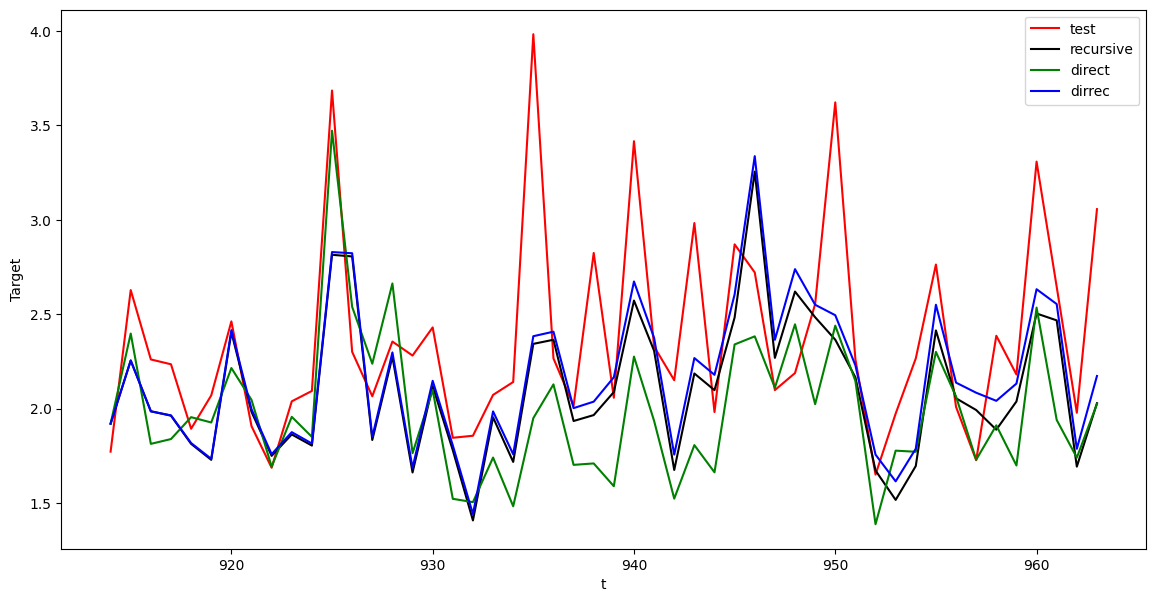

In [1016]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='test', color='red')
plt.plot(y_test.index, preds_rec, label='recursive', color='black')
plt.plot(y_test.index, preds_dir, label='direct', color='green')
plt.plot(y_test.index, preds_dirrec, label='dirrec', color='blue')

plt.legend()
plt.xlabel('t')
plt.ylabel('Target')
plt.show()

In [1017]:
wape_results = pd.DataFrame({
    "Method": ["Recursive", "Direct", "DirRec"],
    "WAPE": [wape_recursive, wape_direct, wape_dirrec]
})

wape_results

,Method,WAPE
0,Recursive,0.155311
1,Direct,0.181345
2,DirRec,0.144220


***В моем случае лучшей оказалась стратегия DirRec. Вероятно, потому что она совмещает преимущества двух подходов.***

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/eKQTEKbYKD9YripL8